# Image Analysis with Python - <font color='orange'>Tutorial Pipeline Solutions</font>

*originally created in 2016*<br>
*updated and converted to a Jupyter notebook in 2017*<br>
*updated and converted to python 3 in 2018*<br>
*by Jonas Hartmann (Gilmour group, EMBL Heidelberg)*<br>

##  Table of Contents

1. [About this Tutorial](#about)
2. [Importing Modules & Packages](#import)
3. [Loading & Handling Image Data](#load)
4. [Preprocessing](#prepro)
5. [Manual Thresholding & Threshold Detection](#thresh)
6. [Adaptive Thresholding](#adaptive)
7. [Improving Masks with Binary Morphology](#morpho)
8. [Connected Components Labeling](#label)
9. [Cell Segmentation by Seeding & Expansion](#seg)
10. [Postprocessing: Removing Cells at the Image Border](#postpro)
11. [Identifying Cell Edges](#edges)
12. [Extracting Quantitative Measurements](#measure)
13. [Simple Analysis & Visualization](#analysis)
14. [Writing Output to Files](#write)
15. [Batch Processing](#batch)

##  About this Tutorial - <font color='orange'> Notes on the Solutions </font> <a id=about></a>

These are the solutions to the tutorial pipeline (see `image_analysis_tutorial.py`). <font color=red>*For the best learning experience, it is highly recommended that you first try to implement a solution yourself!*</font> Only come here if you are totally stuck or if you have a working solution and would like to double-check it.

Note that there are multiple ways of implementing any particular step in the pipeline, so if your solution is different from the solution here, it is not necessarily wrong. However, *some solutions are better than others* because they are...

- **...more readable:**
    - When reading the code, it is obvious and clear what the code is doing
    - The code is clearly commented to help others (and your future self) understand it
    
    
- **...more general:**
    - The code still works if there are minor changes to the data (e.g. size of the image being processed)
    - The code can easily be transformed into a solution for a similar problem
    
    
- **...more computationally efficient:**
    - No unnecessary copies of large datasets are made (memory efficiency)
    - Faster algorithms are used, e.g. array operations instead of loops (CPU efficiency)
    - No unnecessary loading and writing of data (io efficiency)


It is up to you to decide if your solution is better, equally good, or not as good as the solution presented here. Either way, we hope you can learn something by looking at our solutions. **:)**

## Importing Modules & Packages <a id=import></a>

In [1]:
# The numerical array package numpy as np
import numpy as np

#### <font color='orange'>Exercise Solution</font> 

Using the import command as above, follow the instructions in the comments below to import two additional modules that we will be using frequently in this pipeline.

In [2]:
# The plotting module matplotlib.pyplot as plt
import matplotlib.pyplot as plt

# The image processing package scipy.ndimage as ndi
import scipy.ndimage as ndi

#### Side Note for Jupyter Notebook Users

You can configure how the figures made by matplotlib are displayed.

In [3]:
# Set matplotlib backend
%matplotlib inline
#%matplotlib notebook 
#%matplotlib qt 

## Loading & Handling Image Data <a id=load></a>

#### <font color='orange'>Exercise Solution</font>

We will now proceed to load one of the example images and verify that we get what we expect.

In [4]:
# (i) Specify the directory path and file name

# Create a string variable with the name of the file you'd like to load (here: 'example_cells_1.tif').
# Suggested name for the variable: filename
# Note: Paths and filenames can contain slashes, empty spaces and other special symbols, which can cause 
#       trouble for programming languages under certain circumstances. To circumvent such trouble, add 
#       the letter r before your string definition to create a so-called 'raw string', which is not
#       affected by these problems (e.g. `my_raw_string = r"some string with funny symbols: \\\!/~***!"`).
filename = r'example_cells_1.tif'

# If the file is not in the current working directory, you must also have a way of specifying the path
# to the directory where the file is stored. Most likely, your example images are stored in a directory
# called 'example_data' in the same folder as this notebook. Note that you can use either the full path
#  - something like r"/home/jack/data/python_image_analysis/example_data/example_cells_1.tif"
# or the relative path, starting from the current working directory
#   - here that would just be r"example_data"
# Create a string variable with the path to the directory that contains the file you'd like to load.
# Suggested name for the variable: dirpath
dirpath = r'example_data'  # Relative path
#dirpath = r'/home/jack/data/python_image_analysis/example_data/example_cells_1.tif'  # Absolute path 

In [5]:
# (ii) Combine the directory path and file name into one variable, the file path

# Import the function 'join' from the module 'os.path'
# This function automatically takes care of the slashes that need to be added when combining two paths.
from os.path import join

# Use the 'join' function to combine the directory path with the file name and create a new variable.
# Print the result to see that everything is correct (this is always a good idea!)
# Suggested name for the variable: filepath
filepath = join(dirpath, filename)
print(filepath)

example_data\example_cells_1.tif


In [6]:
# (iii) Load the image

# Import the function 'imread' from the module 'skimage.io'.
from skimage.io import imread

# Load 'example_cells_1.tif' and store it in a variable.
# Suggested name for the variable: img
img = imread(filepath)

In [7]:
# (iv) Check that everything is in order

# Check that 'img' is a variable of type 'ndarray' - use Python's built-in function 'type'.
print("Loaded array is of type:", type(img))

# Print the shape of the array using the numpy-function 'shape'. 
# Make sure you understand the output!
print("Loaded array has shape:", img.shape)

# Check the datatype of the individual numbers in the array. You can use the array attribute 'dtype' to do so.
# Make sure you understand the output!
print("Loaded values are of type:", img.dtype)

# SOLUTION NOTE: The dtype should be 'uint8', because these are unsigned 8-bit integer images.
#                This means that the intensity values range from 0 to 255 in steps of 1.

Loaded array is of type: <class 'numpy.ndarray'>
Loaded array has shape: (930, 780)
Loaded values are of type: uint8


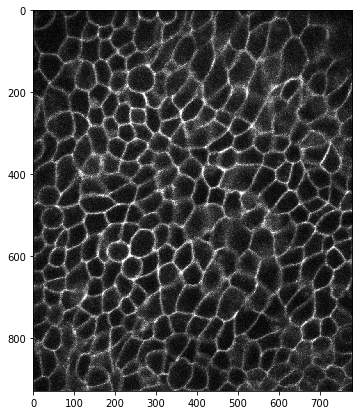

In [8]:
# (v) Look at the image to confirm that everything worked as intended

# To plot the array as an image, use pyplot's functions 'plt.imshow' followed by 'plt.show'. 
# Check the documentation for 'plt.imshow' and note the parameters that can be specified, such as colormap (cmap)
# and interpolation. Since you are working with scientific data, interpolation is unwelcome, so you should set it 
# to "none". The most common cmap for grayscale images is naturally "gray".
# You may also want to adjust the size of the figure. You can do this by preparing the figure canvas with
# the function 'plt.figure' before calling 'plt.imshow'. The canvas size is adjusted using the keyword argument
# 'figsize' when calling 'plt.figure'.
plt.figure(figsize=(7,7))
plt.imshow(img, interpolation='none', cmap='gray')
plt.show()

## Preprocessing <a id=prepro></a>

#### <font color='orange'>Exercise Solution</font>

Perform Gaussian smoothing and visualize the result.

In [9]:
# (i) Create a variable for the smoothing factor sigma, which should be an integer value

sigma = 3

# After implementing the Gaussian smoothing function below, you can modify this variable 
# to find the ideal value of sigma.

In [10]:
# (ii) Perform the smoothing on the image

# To do so, use the Gaussian filter function 'ndi.filters.gaussian_filter' from the 
# image processing module 'scipy.ndimage', which was imported at the start of the tutorial. 
# Check out the documentation of scipy to see how to use this function. 
# Allocate the output to a new variable.
img_smooth = ndi.filters.gaussian_filter(img, sigma)

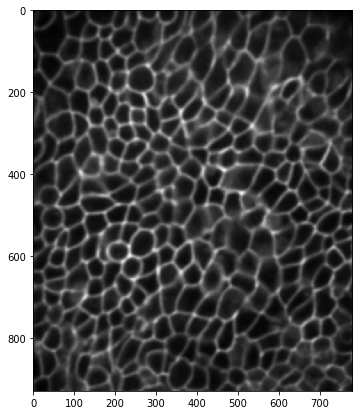

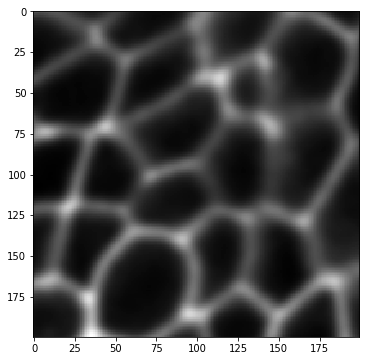

In [11]:
# (iii) Visualize the result using 'plt.imshow'

# Compare with the original image visualized above. 
# Does the output make sense? Is this what you expected? 
# Can you optimize sigma such that the image looks smooth without blurring the membranes too much?
plt.figure(figsize=(7,7))
plt.imshow(img_smooth, interpolation='none', cmap='gray')
plt.show()

# To have a closer look at a specific region of the image, crop that region out and show it in a 
# separate plot. Remember that you can crop arrays by "indexing" or "slicing" them similar to lists.
# Use such "zoomed-in" views throughout this tutorial to take a closer look at your intermediate 
# results when necessary.
plt.figure(figsize=(6,6))
plt.imshow(img_smooth[400:600, 200:400], interpolation='none', cmap='gray')
plt.show()

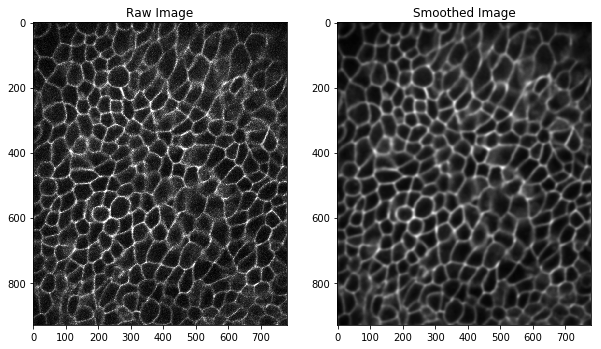

In [12]:
# (iv) BONUS: Show the raw and smoothed images side by side using 'plt.subplots'

fig, ax = plt.subplots(1, 2, figsize=(10,7))
ax[0].imshow(img, interpolation='none', cmap='gray')
ax[1].imshow(img_smooth, interpolation='none', cmap='gray')
ax[0].set_title('Raw Image')
ax[1].set_title('Smoothed Image')
plt.show()

## Manual Thresholding & Threshold Detection <a id=thresh></a>

#### <font color='orange'>Exercise Solution</font>

Try out manual thresholding and automated threshold detection.

In [13]:
# (i) Create a variable for a manually set threshold, which should be an integer

# This can be changed later to find a suitable value.
thresh = 70

In [14]:
# (ii) Perform thresholding on the smoothed image

# Remember that you can use relational (Boolean) expressions such as 'smaller' (<), 'equal' (==)
# or 'greater or equal' (>=) with numpy arrays - and you can directly assign the result to a new
# variable.
mem = img_smooth > thresh

# Check the dtype of your thresholded image
# You should see that the dtype is 'np.bool', which stands for 'Boolean' and means the array
# is now simply filled with 'True' and 'False', where 'True' is the foreground (the regions
# above the threshold) and 'False' is the background.
print(mem.dtype)

bool


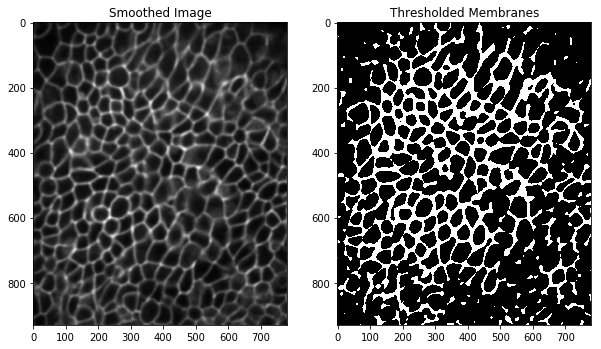

In [15]:
# (iii) Visualize the result

fig, ax = plt.subplots(1, 2, figsize=(10,7))
ax[0].imshow(img_smooth, interpolation='none', cmap='gray')
ax[1].imshow(mem, interpolation='none', cmap='gray')
ax[0].set_title('Smoothed Image')
ax[1].set_title('Thresholded Membranes')
plt.show()

In [16]:
# (iv) Try out different thresholds to find the best one

# If you are using jupyter notebook, you can adapt the code below to
# interactively change the threshold and look for the best one. These
# kinds of interactive functions are called 'widgets' and are very 
# useful in exploratory data analysis to create greatly simplified
# 'User Interfaces' (UIs) on the fly.
# As a bonus exercise, try to understand or look up how the widget works
# and play around with it a bit!

# Prepare widget
from ipywidgets import interact
@interact(thresh=(10,250,10))
def select_threshold(thresh=100):
    
    # Thresholding
    mem = img_smooth > thresh
    
    # Visualization
    plt.figure(figsize=(7,7))
    plt.imshow(mem, interpolation='none', cmap='gray')
    plt.show()

interactive(children=(IntSlider(value=100, description='thresh', max=250, min=10, step=10), Output()), _dom_cl…

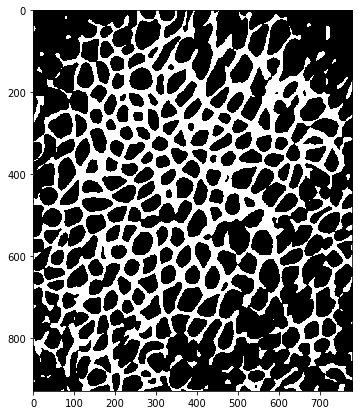

In [17]:
# (v) Perfom automated threshold detection with Otsu's method

# The scikit-image module 'skimage.filters.thresholding' provides
# several threshold detection algorithms. The most popular one 
# among them is Otsu's method. Using what you've learned so far,
# import the 'threshold_otsu' function, use it to automatically 
# determine a threshold for the smoothed image, apply the threshold,
# and visualize the result.

# Import
from skimage.filters.thresholding import threshold_otsu

# Calculate and apply threshold
thresh = threshold_otsu(img_smooth)
mem = img_smooth > thresh
    
# Visualization
plt.figure(figsize=(7,7))
plt.imshow(mem, interpolation='none', cmap='gray')
plt.show()

C:\Users\Jonas Hartmann\Anaconda\envs\py3base\lib\site-packages\matplotlib\axes\_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


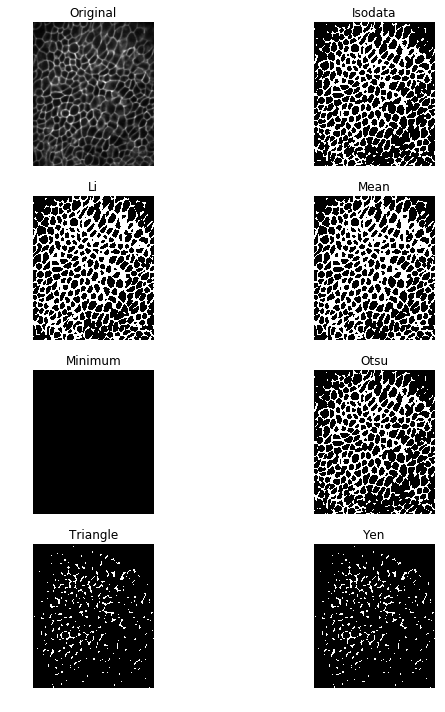

In [18]:
# (vi) BONUS: Did you notice the 'try_all_threshold' function?

# That's convenient! Use it to automatically test the threshold detection
# functions in 'skimage.filters.thresholding'. Don't forget to adjust the
# 'figsize' parameter so the resulting images are clearly visible.
from skimage.filters.thresholding import try_all_threshold
fig = try_all_threshold(img_smooth, figsize=(10,10), verbose=False)

## Adaptive Thresholding <a id=adaptive></a>

#### <font color='orange'>Exercise Solution</font>

Implement the two steps of adaptive background subtraction:

1. Use a strong "mean filter" with a circular `SE` to create the background image.

2. Use the background image for thresholding.

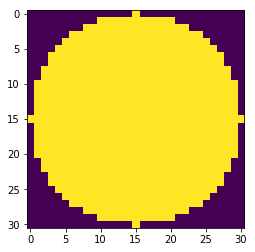

In [19]:
# Step 1
# ------

# The expression below creates circular structuring elements. 
# It is an elegant but complicated piece of code and at the moment it is not 
# necessary for you to understand it in detail. Use it to create structuring 
# elements of different sizes (by changing 'i') and find a way to visualize 
# the result (remember that the SE is just a small 'image').
#
# Try to answer the following questions: 
#
#   - Is the resulting SE really circular?  
#       >>> It is close enough for large i, not so much for small i.
#
#   - Can certain values of 'i' cause problems? If so, why?  
#       >>> Even values create a slight asymmetry! It is best to use only odd values!
#
#   - What value of 'i' should be used for the SE?
#       >>> My first guess was i=30, which is about 3x the membrane diameter. 
#           I tried out some other values but ultimately stuck with this.

# Create SE
i = 31
SE = (np.mgrid[:i,:i][0] - np.floor(i/2))**2 + (np.mgrid[:i,:i][1] - np.floor(i/2))**2 <= np.floor(i/2)**2

# Visualize the result
plt.imshow(SE, interpolation='none')
plt.show()

In [20]:
# (ii) Create the background

# Run a mean filter over the image using the disc SE and assign the output to a new variable.
# Use the function 'skimage.filters.rank.mean'.
from skimage.filters import rank 
bg = rank.mean(img_smooth, selem=SE)

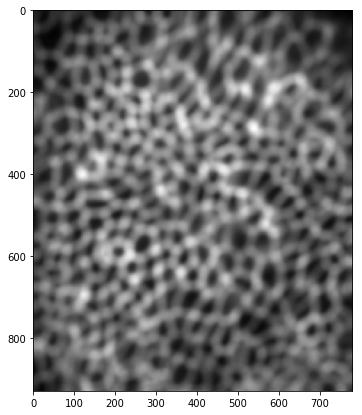

In [21]:
# (iii) Visualize the resulting background image. Does what you get make sense?

plt.figure(figsize=(7,7))
plt.imshow(bg, interpolation='none', cmap='gray')
plt.show()

In [22]:
# Step 2
# ------

# (iv) Threshold the Gaussian-smoothed original image against the background image created in step 1 
#      using a relational expression

mem = img_smooth > bg

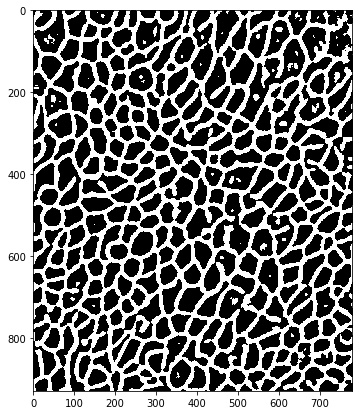

In [23]:
# (v) Visualize and understand the output. 

plt.figure(figsize=(7,7))
plt.imshow(mem, interpolation='none', cmap='gray')
plt.show()

# Are you happy with this result as a membrane segmentation? 
# ->> It's pretty good, except for the speckles that litter the inside of the cells!

## Improving Masks with Binary Morphology <a id=morpho></a>

#### <font color='orange'>Exercise Solution</font>

Improve the membrane segmentation from above with morphological operations.

In [24]:
# (i) Get rid of speckles using binary hole filling

# Use the function 'ndi.binary_fill_holes' for this. Be sure to check the docs to
# understand exactly what it does. For this to work as intended, you will have to 
# invert the mask, which you can do using the function `np.logical_not` or the
# corresponding operator '~'. Again, be sure to understand why this has to be done
# and don't forget to revert the result back.

#mem_holefilled = np.logical_not(ndi.binary_fill_holes(np.logical_not(mem)))  # Long form
mem_holefilled = ~ndi.binary_fill_holes(~mem)  # Short form

In [25]:
# (ii) Try out other morphological operations to further improve the membrane mask

# The various operations are available in the ndimage module, for example 'ndi.binary_closing'.
# Play around and see how the different functions affect the mask. Can you optimize the mask, 
# for example by closing gaps?
# Note that the default SE for these functions is a square. Feel free to create another disc-
# shaped SE and see how that changes the outcome.
# BONUS: If you pay close attention, you will notice that some of these operations introduce 
# artifacts at the image boundaries. Can you come up with a way of solving this?

# New circular SE of appropriate size (determined by trial and error)
i = 15
SE = (np.mgrid[:i,:i][0] - np.floor(i/2))**2 + (np.mgrid[:i,:i][1] - np.floor(i/2))**2 <= np.floor(i/2)**2

# One solution to the boundary artefact issue is padding with the reflection.
# 'Padding' refers to the extension of the image at the boundaries, in this case using
# a 'reflection' of the pixel values next to the boundary. If morphological operations 
# are done on the padded image, the boundary artefacts will occur in the padded region
# outside the original image, which can simply be cropped out again at the end.
pad_size = i+1
mem_padded = np.pad(mem_holefilled, pad_size, mode='reflect')

# Binary closing works well to round off the membranes and close gaps
mem_final = ndi.binary_closing(mem_padded, structure=SE)

# This slicing operation crops the padded image back to the original size
mem_final = mem_final[pad_size:-pad_size, pad_size:-pad_size]

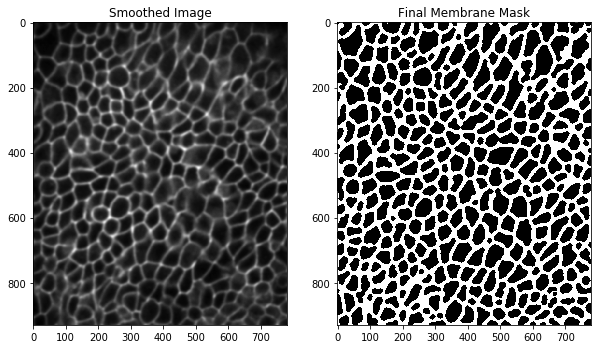

In [26]:
# (iii) Visualize the final result

fig, ax = plt.subplots(1, 2, figsize=(10,7))
ax[0].imshow(img_smooth, interpolation='none', cmap='gray')
ax[1].imshow(mem_final, interpolation='none', cmap='gray')
ax[0].set_title('Smoothed Image')
ax[1].set_title('Final Membrane Mask')
plt.show()

## Connected Components Labeling <a id=label></a>

#### <font color='orange'>Exercise Solution</font>

Use your membrane segmentation for connected components labeling.

In [27]:
# (i) Label connected components

# Use the function 'ndi.label' from the 'ndimage' module. 
# Note that this function labels foreground pixels (1s, not 0s), so you may need 
# to invert your membrane mask just as for hole filling above.
# Also, note that 'ndi.label' returns another result in addition to the labeled 
# image. Read up on this in the function's documention and make sure you don't
# mix up the two outputs!

cell_labels, _ = ndi.label(~mem_final)

# Solution note: For functions with multiple outputs (here the labeled image on
# the one hand and the number of detected objects on the other), it is a python
# convention to unpack those outputs that will not be used in the remainder of 
# code into the variable '_' (underscore). This makes it clear to those reading
# the code that the function returns multiple things but some of them are not
# important in this case.

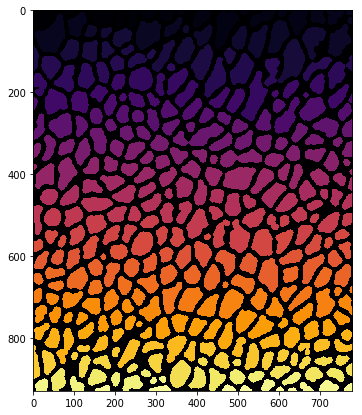

In [28]:
# (ii) Visualize the output

# Here, it is no longer ideal to use a 'gray' colormap, since we want to visualize that each
# cell has a unique ID. Play around with different colormaps (check the docs to see what
# types of colormaps are available) and choose one that you are happy with.

plt.figure(figsize=(7,7))
plt.imshow(cell_labels, interpolation='none', cmap='inferno')
plt.show()

## Cell Segmentation by Seeding & Expansion <a id=seg></a>

#### <font color='orange'>Exercise Solution</font>

Find seeds using the distance transform approach.

In [29]:
# (i) Run a distance transform on the membrane mask

# Use the function 'ndi.distance_transform_edt'.
# You may need to invert your membrane mask so the distances are computed on
# the cells, not on the membranes.
dist_trans = ndi.distance_transform_edt(~mem_final)

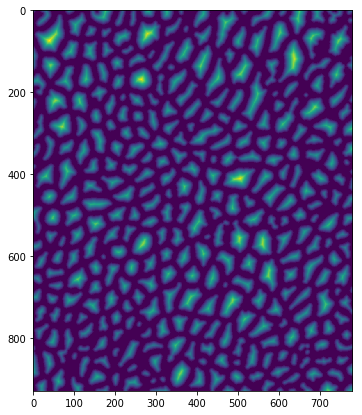

In [30]:
# (ii) Visualize the output and understand what you are seeing.

plt.figure(figsize=(7,7))
plt.imshow(dist_trans, interpolation='none', cmap='viridis')
plt.show()

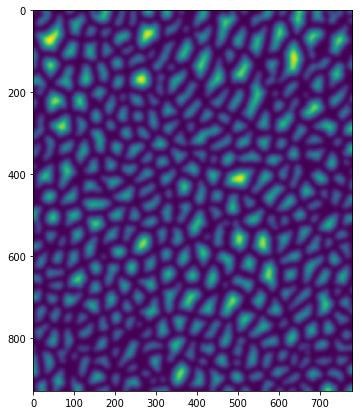

In [31]:
# (iii) Smoothen the distance transform

# Use 'ndi.filters.gaussian_filter' to do so.
# You will have to optimize your choice of 'sigma' based on the outcome below.

# Applying the filter
dist_trans_smooth = ndi.filters.gaussian_filter(dist_trans, sigma=5)

# Visualizing
plt.figure(figsize=(7,7))
plt.imshow(dist_trans_smooth, interpolation='none', cmap='viridis')
plt.show()

In [32]:
# (iv) Retrieve the local maxima (the 'peaks') from the distance transform

# Use the function 'peak_local_max' from the module 'skimage.feature'. By default, this function will return the
# indices of the pixels where the local maxima are. However, we instead need a boolean mask of the same shape 
# as the original image, where all the local maximum pixels are labeled as `1` and everything else as `0`.
# This can be achieved by setting the keyword argument 'indices' to False.
from skimage.feature import peak_local_max
seeds = peak_local_max(dist_trans_smooth, indices=False, min_distance=10)

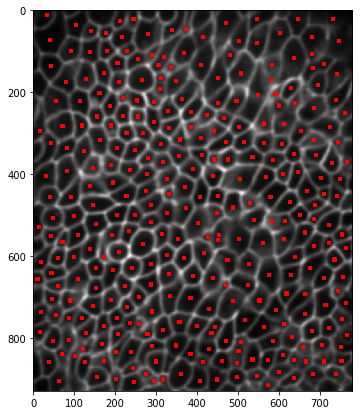

In [33]:
# (v) Visualize the output as an overlay on the raw (or smoothed) image

# If you just look at the local maxima image, it will simply look like a bunch of distributed dots.
# To get an idea if the seeds are well-placed, you will need to overlay these dots onto the original image.

# To do this, it is important to first understand a key point about how the 'pyplot' module works: 
# every plotting command is slapped on top of the previous plotting commands, until everything is ultimately 
# shown when 'plt.show' is called. Hence, you can first plot the raw (or smoothed) input image and then
# plot the seeds on top of it before showing both with 'plt.show'.

# As you can see if you try this, you will not get the desired result because the zero values in seed array
# are painted in black over the image you want in the background. To solve this problem, you need to mask 
# these zero values before plotting the seeds. You can do this by creating an appropriately masked array
# using the function 'np.ma.array' with the keyword argument 'mask'. 
# Check the docs or Stack Overflow to figure out how to do this.

# BONUS: As an additional improvement to the visualization, use 'ndi.filters.maximum_filter' to dilate the 
# seeds a little bit, making them bigger and thus better visible.

# Dilate seeds
seeds_dil = ndi.filters.maximum_filter(seeds, size=10)

# Create plot
plt.figure(figsize=(7,7))
plt.imshow(img_smooth, interpolation='none', cmap='gray')
plt.imshow(np.ma.array(seeds_dil, mask=seeds_dil==0), interpolation='none', cmap='autumn')
plt.show()

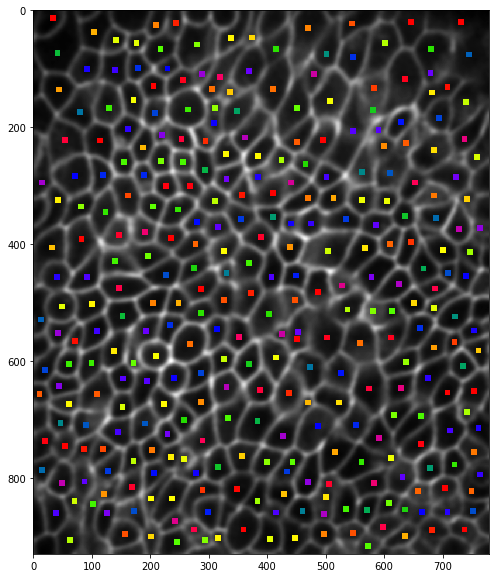

In [34]:
# (vii) Label the seeds

# Use connected component labeling to give each cell seed a unique ID number.
seeds_labeled = ndi.label(seeds)[0]

# Visualize the final result (the labeled seeds) as an overlay on the raw (or smoothed) image
seeds_labeled_dil = ndi.filters.maximum_filter(seeds_labeled, size=10)  # Expand a bit for visualization
plt.figure(figsize=(10,10))
plt.imshow(img_smooth, interpolation='none', cmap='gray')
plt.imshow(np.ma.array(seeds_labeled_dil, mask=seeds_labeled_dil==0), interpolation='none', cmap='prism')
plt.show()

### Expansion by Watershed

#### <font color='orange'>Exercise Solution</font>

Expand your seeds by means of a watershed expansion.

In [35]:
# (i) Perform watershed

# Use the function 'watershed' from the module 'skimage.morphology'.
# Use the labeled cell seeds and the smoothed membrane image as input.
from skimage.morphology import watershed
ws = watershed(img_smooth, seeds_labeled)

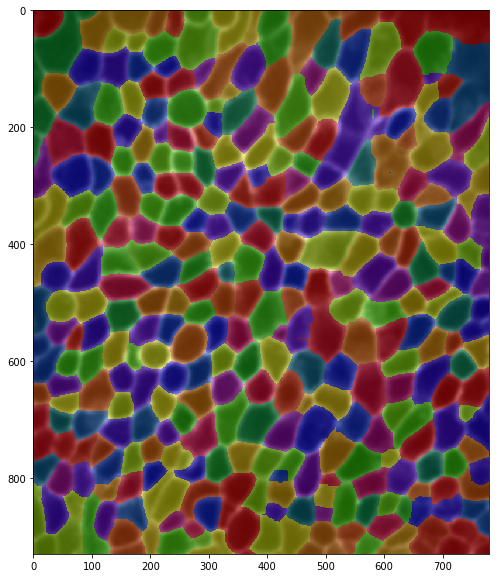

In [36]:
# (ii) Show the result as transparent overlay over the smoothed input image

# Like the masked overlay of the seeds, this can be achieved by making two calls to 'imshow',
# one for the background image and one for the segmentation. Instead of masking away background,
# this time you simply make the segmentation image semi-transparent by adjusting the keyword 
# argument 'alpha' of the 'imshow' function, which specifies opacity.
# Be sure to choose an appropriate colormap that allows you to distinguish the segmented cells
# even if cells with a very similar ID are next to each other (I would recommend 'prism').
plt.figure(figsize=(10,10))
plt.imshow(img_smooth, interpolation='none', cmap='gray')
plt.imshow(ws, interpolation='none', cmap='prism', alpha=0.4)
plt.show()

#### *A Note on Segmentation Quality*

This concludes the segmentation of the cells in the example image. Depending on the quality you achieved in each step along the way, the final segmentation may be of greater or lesser quality (in terms of over-/under-segmentation errors).

It should be noted that the segmentation will likely *never* be perfect, as there is usually a trade-off between over- and undersegmentation.

This raises an important question: ***When should I stop trying to optimize my segmentation?***

There is no absolute answer to this question but the best answer is probably this: ***When you can use it to address your biological questions!***

*Importantly, this implies that you should already have relatively clear questions in mind when you are working on the segmentation!*

## Postprocessing: Removing Cells at the Image Border <a id=postpro></a>

#### <font color='orange'> Exercise Solution </font>

Iterate through all the cells in your segmentation and remove those touching the image border.

In [37]:
# (i) Create an image border mask

border_mask = np.zeros(ws.shape, dtype=np.bool)
border_mask = ndi.binary_dilation(border_mask, border_value=1)

In [38]:
# (ii) 'Delete' the cells at the border

# When modifying a segmentation (in this case by deleting some cells), it makes sense
# to work on a copy of the array, not on the original. This avoids unexpected behaviors,
# especially within jupyter notebooks. Use the function 'np.copy' to copy an array.
clean_ws = np.copy(ws)

# Iterate over the IDs of all the cells in the segmentation. Use a for-loop and the 
# function 'np.unique' (remember that each cell in our segmentation is labeled with a 
# different integer value).
for cell_ID in np.unique(ws):

    # Create a mask that contains only the 'current' cell of the iteration
    # Hint: Remember that the comparison of an array with some number (array==number)
    #       returns a Boolean mask of the pixels in 'array' whose value is 'number'.
    cell_mask = ws==cell_ID 
    
    # Using the cell mask and the border mask from above, test if the cell has pixels touching 
    # the image border or not.
    # Hint: 'np.logical_and'
    cell_border_overlap = np.logical_and(cell_mask, border_mask)  # Overlap of cell mask and boundary mask
    total_overlap_pixels = np.sum(cell_border_overlap)            # Sum overlapping pixels

    # If a cell touches the image boundary, delete it by setting its pixels in the segmentation to 0.
    if total_overlap_pixels > 0: 
        clean_ws[cell_mask] = 0

In [39]:
# OPTIONAL: re-label the remaining cells to keep the numbering consistent from 1 to N (with 0 as background).

for new_ID, cell_ID in enumerate(np.unique(clean_ws)[1:]):  # The [1:] excludes 0 from the list (background)!
    clean_ws[clean_ws==cell_ID] = new_ID+1                  # The same here for the +1

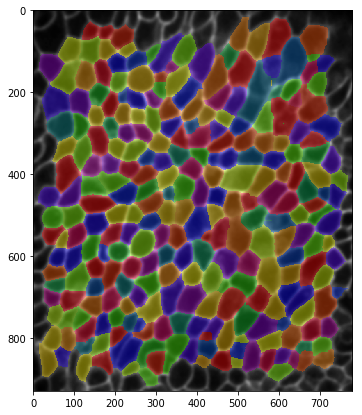

In [40]:
# (iii) Visualize the result

# Show the result as transparent overlay over the raw or smoothed image. 
# Here you have to combine alpha (to make cells transparent) and 'np.ma.array'
# (to hide empty space where the border cells were deleted).

plt.figure(figsize=(7,7))
plt.imshow(img_smooth, interpolation='none', cmap='gray')
plt.imshow(np.ma.array(clean_ws, mask=clean_ws==0), interpolation='none', cmap='prism', alpha=0.4)
plt.show()

## Identifying Cell Edges <a id=edges></a>

#### <font color='orange'>Exercise Solution</font>

Create a labeled mask of cell edges.

In [41]:
# (i) Create an array of the same size and data type as the segmentation but filled with only zeros

edges = np.zeros_like(clean_ws)

In [42]:
# (ii) Iterate over the cell IDs
for cell_ID in np.unique(clean_ws)[1:]:

    # (iii) Erode the cell's mask by 1 pixel
    # Hint: 'ndi.binary_erode'
    cell_mask = clean_ws==cell_ID
    eroded_cell_mask = ndi.binary_erosion(cell_mask, iterations=1) # Increase iterations to make boundary wider!
    
    # (iv) Create the cell edge mask
    # Hint: 'np.logical_xor'
    edge_mask = np.logical_xor(cell_mask, eroded_cell_mask)
    
    # (v) Add the cell edge mask to the empty array generated above, labeling it with the cell's ID
    edges[edge_mask] = cell_ID

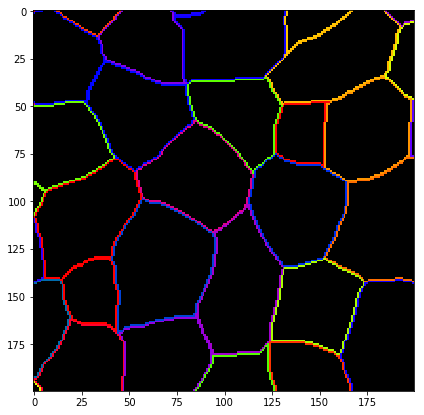

In [43]:
# (vi) Visualize the result

# Note: Because the lines are so thin (1pxl wide), they may not be displayed correctly in small figures.
#       You can 'zoom in' by showing a sub-region of the image which is then rendered bigger. You can
#       also go back to the edge identification code and make the edges multiple pixels wide (but keep 
#       in mind that this will have an effect on your quantification results!).

plt.figure(figsize=(7,7))
plt.imshow(np.zeros_like(edges)[300:500, 300:500], cmap='gray', vmin=0, vmax=1)  # Simple black background
plt.imshow(np.ma.array(edges, mask=edges==0)[300:500, 300:500], interpolation='none', cmap='prism')
plt.show()

## Extracting Quantitative Measurements <a id=measure></a>

#### <font color='orange'>Exercise Solution</font>

Extract the measurements listed above for each cell and collect them in a dictionary.

Note: The ideal data structure for data like this is the `DataFrame` offered by the module `Pandas`. However, for the sake of simplicty, we will here stick with a dictionary of lists.

In [44]:
# (i) Create a dictionary that contains a key-value pairing for each measurement

# The keys should be strings describing the type of measurement (e.g. 'intensity_mean') and 
# the values should be empty lists. These empty lists will be filled with the results of the
# measurements

results = {"cell_id"      : [],
           "int_mean"     : [],
           "int_mem_mean" : [],
           "cell_area"    : [],
           "cell_edge"    : []}

# Solution note: the spacing between the strings and colons doesn't matter for the code's
# execution. It is used solely to make the code more readable!

In [45]:
# (ii) Record the measurements for each cell

# Iterate over the segmented cells ('np.unique').
# Inside the loop, create a mask for the current cell and use it to extract the measurements listed above. 
# Add them to the appropriate list in the dictionary using the 'append' method.
# Hint: Remember that you can get out all the values within a masked area by indexing the image 
#       with the mask. For example, 'np.mean(image[cell_mask])' will return the mean of all the 
#       intensity values of 'image' that are masked by 'cell_mask'!

# Iterate over cell IDs
for cell_id in np.unique(clean_ws)[1:]:

    # Mask the current cell and cell edge
    cell_mask = clean_ws==cell_id
    edge_mask = edges==cell_id
    
    # Get the measurements
    results["cell_id"].append(cell_id)
    results["int_mean"].append(np.mean(img[cell_mask]))
    results["int_mem_mean"].append(np.mean(img[edge_mask]))
    results["cell_area"].append(np.sum(cell_mask))
    results["cell_edge"].append(np.sum(edge_mask))

In [46]:
# (iii) Print the results and check that they make sense

for key in results.keys(): 
    print(key + ":", results[key][:5], '\n')

cell_id: [1, 2, 3, 4, 5] 

int_mean: [45.65185185185185, 55.141110065851365, 45.19132473622509, 43.14208333333333, 35.132607619990104] 

int_mem_mean: [89.85714285714286, 117.09821428571429, 92.08984375, 104.47928994082841, 71.71428571428571] 

cell_area: [1350, 1063, 4265, 2400, 4042] 

cell_edge: [126, 112, 256, 169, 224] 



## Simple Analysis & Visualisation <a id=analysis></a>

#### <font color='orange'>Exercise Solution</font>

Analyze and plot the extracted data in a variety of ways.

In [47]:
# (i) Familiarize yourself with the data structure of the results dict and summarize the results

# Recall that dictionaries are unordered; a dataset of interest is accessed through its key.
# In our case, the datasets inside the dict are lists of values, ordered in the same order
# as the cell IDs. 

# For each dataset in the results dict, print its name (the key) along with its mean, standard 
# deviation, maximum, minimum, and median. The appropriate numpy methods (e.g. 'np.median') work
# with lists just as well as with arrays.

# Custom function for nice printing of summary statistics.
# Note the use of format strings for nice number padding.
def print_summary(data):
    print( "  Mean:    {:7.2f}".format(np.mean(data))   )
    print( "  Stdev:   {:7.2f}".format(np.std(data))    )
    print( "  Max:     {:7.2f}".format(np.max(data))    )
    print( "  Min:     {:7.2f}".format(np.min(data))    )
    print( "  Median:  {:7.2f}".format(np.median(data)) )

# Calling the custom function for each dataset
for key in results.keys():
    print( '\n'+key )
    print_summary(results[key])
    
# There are also pre-made functions to get summary statistics,
# for example 'scipy.stats.describe'.
from scipy.stats import describe
stat_summary = describe(results['int_mean'])

print( '\nscipy.stats.describe of int_mean' )
for key in stat_summary._asdict().keys():
    print( ' ', key+': ', stat_summary._asdict()[key] )


cell_id
  Mean:     136.00
  Stdev:     78.23
  Max:      271.00
  Min:        1.00
  Median:   136.00

int_mean
  Mean:      57.22
  Stdev:     11.14
  Max:      107.12
  Min:       32.09
  Median:    56.28

int_mem_mean
  Mean:     120.08
  Stdev:     24.67
  Max:      185.31
  Min:       40.00
  Median:   120.33

cell_area
  Mean:    2129.03
  Stdev:    972.44
  Max:     6900.00
  Min:        3.00
  Median:  2091.00

cell_edge
  Mean:     162.82
  Stdev:     45.96
  Max:      400.00
  Min:        3.00
  Median:   161.00

scipy.stats.describe of int_mean
  nobs:  271
  minmax:  (32.08815520762423, 107.11764705882354)
  mean:  57.22013803900666
  variance:  124.45154736967352
  skewness:  0.8123253075124528
  kurtosis:  1.552946287021805


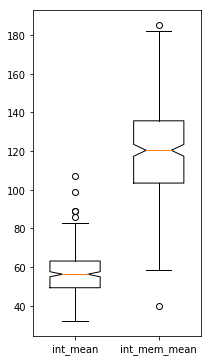

In [48]:
# (ii) Create a box plot showing the mean cell and mean membrane intensities for both channels. 

# Use the function 'plt.boxplot'. Use the 'label' keyword of 'plt.boxplot' to label the x axis with 
# the corresponding key names. Feel free to play around with the various options of the boxplot 
# function to make your plot look nicer. Remember that you can first call 'plt.figure' to adjust 
# settings such as the size of the plot.

plt.figure(figsize=(3,6))
plt.boxplot([results['int_mean'], results['int_mem_mean']], 
            labels=['int_mean', 'int_mem_mean'],
            widths=0.6, notch=True)
plt.show()

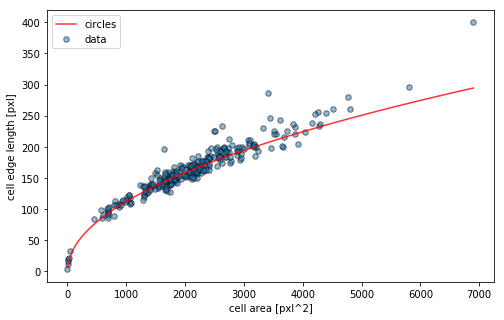

In [49]:
# (iii) Create a scatter plot of cell outline length over cell area

# Use the function 'plt.scatter' for this. Be sure to properly label the 
# plot using 'plt.xlabel' and 'plt.ylabel'.

plt.figure(figsize=(8,5))
plt.scatter(results["cell_area"], results["cell_edge"],
            edgecolor='k', s=30, alpha=0.5)
plt.xlabel("cell area [pxl^2]")
plt.ylabel("cell edge length [pxl]")

# BONUS: Do you understand why you are seeing the pattern this produces? 
# ->> The curve reflects how circumference scales with area!

# Can you generate a 'null model' curve that assumes all cells to be circular? 
cell_area_range = np.linspace(min(results["cell_area"]), max(results["cell_area"]), num=100)
circle_circumference = 2 * np.pi * np.sqrt( cell_area_range / np.pi )
plt.plot(cell_area_range, circle_circumference, color='r', alpha=0.8)
plt.legend(['circles', 'data'], loc=2, fontsize=10)
plt.show()

# What is the result? Do you notice something odd about it? What could be the reason for
# this and how could it be fixed?
# ->> In general, the cells don't deviate all that much from the circular case.
# ->> Strangely, some cells have a smaller outline than the circumference of a circle
#     of equivalent area. This is mathematically impossible.
# ->> A possible reason could be that the measures are taken in pixels, which leads
#     to a so-called discretization error. It could be fixed by "meshing" the cell
#     outline and interpolating a more accurate measurement of circumference.

In [50]:
# (iv) Perform a linear fit of membrane intensity over cell area

# Use the function 'linregress' from the module 'scipy.stats'. Be sure to read the docs to
# understand the output of this function. Print the output.

# Compute linear fit
from scipy.stats import linregress
linfit = linregress(results["cell_area"], results["int_mem_mean"])

# Print all the results
linprops = ['slope','interc','rval','pval','stderr']
for index,prop in enumerate(linprops):
    print( prop, '\t', '{:4.2e}'.format(linfit[index]) )

slope 	 4.38e-03
interc 	 1.11e+02
rval 	 1.73e-01
pval 	 4.39e-03
stderr 	 1.52e-03


In [51]:
# (v) Think about the result

# Note that the fit seems to return a highly significant p-value but a very low correlation 
# coefficient (r-value). Based on prior knowledge, we would not expect a linear correlation of 
# this sort to be present in our data. 
#
# This should prompt several questions:
#   1) What does this p-value actually mean? Check the docs of 'linregress'!
#       ->> This p-value only means that, given a linear fit through this data, the slope of the
#           fit is very unlikely to be zero. However, it does not make a statement on whether or
#           not it makes sense to use a linear fit in the first place. Looking at the scatterplot
#           below or at the correlation coefficient r, it is clear that a linear fit on this data
#           is not meaningful.
#       ->> Note also: With single-cell approaches, we quickly get to a large number of data points. 
#           This makes hypothesis testing in general less useful, as p-values tend to become very
#           small even if the null hypothesis holds. It makes sense to instead report effect sizes.
#           This is a tricky topic but well worth reading up on.
#
#   2) Could there be artifacts in our segmentation that bias this analysis?
#       ->> Oversegmentation is an important source of bias here. If a cell is oversegmented,
#           it will be considered as two or three cells. These will naturally have a lower
#           cell area and will naturally have a lower membrane intensity because some of their
#           edges are actually not on membranes. In other words, they will fall into the bottom
#           left of the plot, distorting the data.
#
# In general, it's always good to be very careful when doing any kind of data analysis. Make sure you 
# understand the functions you are using and always check for possible errors or sources of bias!

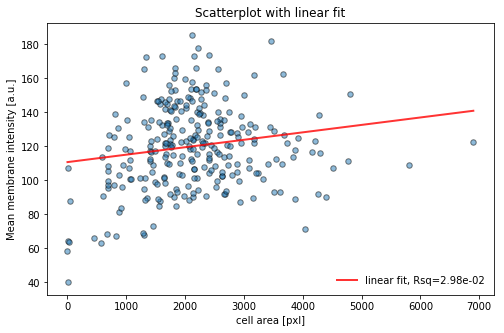

In [52]:
# (vi) Overlay the linear fit onto a scatter plot

# Recall that a linear function is defined by `y = slope * x + intercept`.

# To define the line you'd like to plot, you need two values of x (the starting point and
# and the end point of the line). What values of x make sense? Can you get them automatically?
#   ->> The max and min values in the data are a good choice.
x_vals = [min(results["cell_area"]), max(results["cell_area"])]

# When you have the x-values for the starting point and end point, get the corresponding y 
# values from the fit through the equation above.
y_vals = [linfit[0] * x_vals[0] + linfit[1], linfit[0] * x_vals[1] + linfit[1]]

# Plot the line with 'plt.plot'. Adjust the line's properties so it is well visible.
# Note: Remember that you have to create the scatterplot before plotting the line so that
#       the line will be placed on top of the scatterplot.
plt.figure(figsize=(8,5))
plt.scatter(results["cell_area"], results["int_mem_mean"], 
            edgecolor='k', s=30, alpha=0.5)
plt.plot(x_vals, y_vals, color='red', lw=2, alpha=0.8)

# Use 'plt.legend' to add information about the line to the plot.
plt.legend(["linear fit, Rsq={:4.2e}".format(linfit[2]**2.0)], frameon=False, loc=4)

# Label the plot and finally show it with 'plt.show'.
plt.xlabel("cell area [pxl]")
plt.ylabel("Mean membrane intensity [a.u.]")
plt.title("Scatterplot with linear fit")
plt.show()

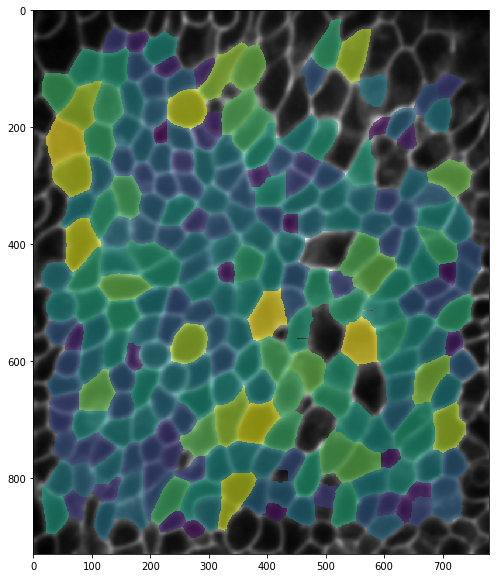

In [53]:
# (vii) Map the cell area back onto the image as a 'heatmap'

# Scale the cell area data to 8bit so that it can be used as pixel intensity values.
# Hint: if the largest cell area should correspond to the value 255 in uint8, then 
#       the other cell areas correspond to 'cell_area * 255 / largest_cell_area'.
# Hint: To perform an operation on all cell area values at once, convert the list 
#       of cell areas to a numpy array.
areas_8bit = np.array(results["cell_area"]) / max(results["cell_area"]) * 255

# Initialize a new image array; all values should be zeros, the shape should be identical 
# to the images we worked with before and the dtype should be uint8.
area_map = np.zeros_like(clean_ws, dtype=np.uint8) 

# Iterate over the segmented cells. In addition to the cell IDs, the for-loop should
# also include a simple counter (starting from 0) with which the area measurement can be 
# accessed by indexing.
for index, cell_id in enumerate(results["cell_id"]):
    
    # Mask the current cell and assign the cell's (re-scaled) area value to the cell's pixels.
    area_map[clean_ws==cell_id] = areas_8bit[index]

# Visualize the result as a colored semi-transparent overlay over the raw/smoothed original input image.
# BONUS: See if you can exclude outliers to make the color mapping more informative!

# Mask of outliers (the largest and smallest 5% of all cells)
outlier_mask = np.logical_or(area_map > np.percentile(areas_8bit, 95),
                             area_map < np.percentile(areas_8bit, 5))

# Mask of all regions to leave blank (outliers + image boundary cells)
full_mask = np.logical_or(area_map==0, outlier_mask)

# Create the plot
plt.figure(figsize=(10,10))
plt.imshow(img_smooth, interpolation='none', cmap='gray')
plt.imshow(np.ma.array(area_map, mask=full_mask),
           interpolation='none', cmap='viridis', alpha=0.6)
plt.show()

## Writing Output to Files <a id=write></a>

#### <font color='orange'>Exercise Solution</font>

Write the generated data into a variety of different output files.

In [54]:
# (i) Write one or more of the images you produced to a tif file

# Use the function 'imsave' from the 'skimage.io' module. Make sure that the array you are 
# writing is of integer type. If necessary, you can use the method 'astype' for conversions, 
# e.g. 'some_array.astype(np.uint8)' or 'some_array.astype(np.uint16)'. Careful when 
# converting a segmentation to uint8; if there are more than 255 cells, the 8bit format
# doesn't have sufficient bit-depth to represent all cell IDs!
#
# You can also try adding the segmentation to the original image, creating an image with
# two channels, one of them being the segmentation. 
#
# After writing the file, load it into Fiji and check that everything worked as intended.

from skimage.io import imsave
imsave("example_cells_1_edges.tif", edges.astype(np.uint16))

C:\Users\Jonas Hartmann\Anaconda\envs\py3base\lib\site-packages\skimage\io\_io.py:132: UserWarning: example_cells_1_edges.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


In [55]:
# (ii) Write a figure to a png or pdf

# Recreate the scatter plot from above (with or without the regression line), then save the figure
# as a png using 'plt.savefig'. Alternatively, you can also save it to a pdf, which will create a
# vector graphic that can be imported into programs like Adobe Illustrator.

# Create plot (but don't show)
plt.scatter(results["cell_area"], results["int_mem_mean"], 
            edgecolor='k', s=30, alpha=0.5)
plt.plot(x_vals, y_vals, color='red', lw=2, alpha=0.8)
plt.legend(["linear fit, Rsq={:4.2e}".format(linfit[2]**2.0)], frameon=False, loc=4)
plt.xlabel("cell area [pxl]")
plt.ylabel("Mean membrane intensity [a.u.]")
plt.title("Scatterplot with linear fit")

# Save as png and pdf
plt.savefig('example_cells_1_scatterFit.png')
plt.savefig('example_cells_1_scatterFit.pdf')
plt.clf()  # Clear the figure buffer

<Figure size 432x288 with 0 Axes>

In [56]:
# (iii) Save the segmentation as a numpy file

# Numpy files allow fast storage and reloading of numpy arrays. Use the function 'np.save'
# to save the array and reload it using 'np.load'.

np.save("example_cells_1_seg", clean_ws)  # Save
seg = np.load("example_cells_1_seg.npy")  # Load
print(clean_ws.shape, seg.shape)

(930, 780) (930, 780)


In [57]:
# (iv) Save the result dictionary as a pickle file

# Pickling is a way of generating generic files from almost any python object, which can easily
# be reloaded into python at a later point in time.
# You will need to open an empty file object using 'open' in write mode ('w'). It's best to do 
# so using the 'with'-statement (context manager) to make sure that the file object will be closed
# automatically when you are done with it.
# Use the function 'pickle.dump' from the 'pickle' module to write the results to the file.
# Hint: Refer to the python documention for input and output to understand how file objects are
#       handled in python in general.

import pickle
with open('example_cells_1_results.pkl','wb') as outfile:
    pickle.dump(results, outfile)

# Note: Pickled files can be re-loaded again as follows:
with open('example_cells_1_results.pkl', 'rb') as infile:
    results_reloaded = pickle.load(infile)
    print(results_reloaded.keys())

dict_keys(['cell_id', 'int_mean', 'int_mem_mean', 'cell_area', 'cell_edge'])


In [58]:
# (v) Write a tab-separated text file of the results dict

# The most generic way of saving numeric results is a simple text file. It can be imported into 
# pretty much any other program.

# To write normal text files, open an empty file object in write mode ('w') using the 'with'-statement.
with open('example_cells_1_results.txt','w') as outfile:

    # Use the 'file_object.write(string)' method to write strings to the file, one line at a time,
    # First, write the header of the data (the result dict keys), separated by tabs ('\t'). 
    # It makes sense to first generate a complete string with all the headers and then write this 
    # string to the file as one line. Note that you will need to explicitly write 'newline' characters 
    # ('\n') at the end of the line to switch to the next line.
    # Hint: the string method 'join' is very useful here!
    header_string = '\t'.join(results.keys()) + '\n'
    outfile.write(header_string)

    # After writing the headers, iterate over all the cells and write the result data to the file line
    # by line, by creating strings similar to the header string.
    for index in range(len(results['cell_id'])):
        data_string = '\t'.join([str(results[key][index]) for key in results.keys()]) + '\n'
        outfile.write(data_string)

# After writing the data, have a look at the output file in a text editor or in a spreadsheet
# program like Excel.

## Batch Processing <a id=batch></a>

#### <font color='orange'>Exercise Solution</font>

Convert the pipeline to a single function in a python script.

Import that function and write the code necessary to iterate over all input files in a folder, apply the function to each file, and collect the results.

#### Solution Note

The converted version of the pipeline can be found in `batch_processing_solution.py`. 

Note that the most of the exercise comments have been removed so it doesn't look too cluttered. However, this level of clean-up is probably a bit extreme; it is generally recommended to retain at least basic comments on the purpose of each code block. 

Also note that a doc string was added to the function definition (the string designated with three `"""` at the start and end, directly under the function definition). This is a very useful reference, since it is automatically recognized as a help message by Jupyter notebook (and other IDEs), so you can easily double-check what an imported function does, for example by typing `run_pipeline?` in a code cell.

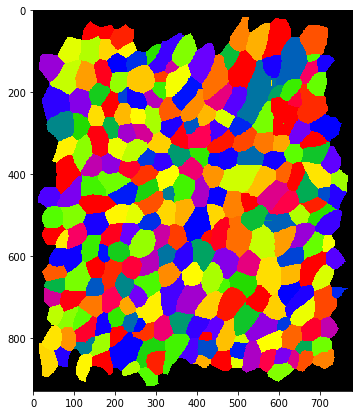

In [59]:
# (i) Test if your pipeline function actually works

# Import your function using the normal python syntax for imports, like this:
#   from your_module import your_function
# Run the function and visualize the resulting segmentation. Make sure everything works as intended.

from batch_processing_solution import run_pipeline
pip_seg, pip_results = run_pipeline(r"example_data", r'example_cells_1.tif')

plt.figure(figsize=(7,7))
plt.imshow(np.zeros_like(pip_seg), interpolation='none', cmap='gray', vmax=1)  # Simple black background
plt.imshow(np.ma.array(pip_seg, mask=pip_seg==0), interpolation='none', cmap='prism')
plt.show()

In [60]:
# (ii) Get all relevant filenames from the input directory

# Use the function 'listdir' from the module 'os' to get a list of all the files
# in a directory. Find a way to filter out only the relevant input files, namely
# "example_cells_1.tif" and "example_cells_2.tif". Of course, one would usually
# do this for many more images, otherwise it's not worth the effort.
# Hint: Loop over the filenames and use if statements to decide which ones to 
#       keep and which ones to throw away.

# Get all files
dirpath = r"example_data"
from os import listdir
filelist = listdir(dirpath)

# Filter for target files: simple option
# Note that this will use ALL files with a .tif ending, which in some circumstances
# may include files that are not supposed to be used!
target_files = []
for fname in filelist:
    if fname.endswith('.tif'):
        target_files.append(fname)
print(target_files)

# Filter for target files: advanced option using regex and a list comprehension
import re
target_pattern = re.compile("^example_cells_\d+\.tif$")
target_files = [fname for fname in filelist if target_pattern.match(fname)]
print(target_files)

['example_cells_1.tif', 'example_cells_2.tif']
['example_cells_1.tif', 'example_cells_2.tif']


In [61]:
# (iii) Iterate over the relevant input filenames and run the pipeline function

# Be sure to collect the output of the pipeline function in a way that allows
# you to trace it back to the file it came from. You could for example use a
# dictionary with the filenames as keys.

# Initialize empty dictionaries
all_seg = {}
all_results = {}

# Iterate over files and run pipeline for each
for fname in target_files:
    pip_seg, pip_results = run_pipeline(dirpath, fname)
    all_seg[fname] = pip_seg
    all_results[fname] = pip_results

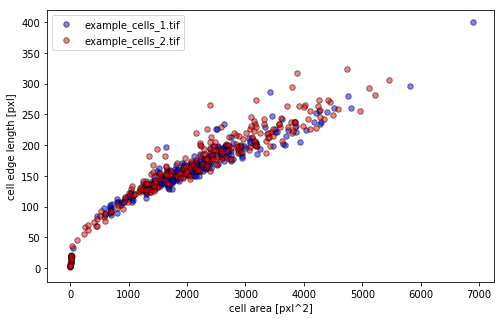

In [62]:
# (iv) Recreate one of the scatterplots from above, but this time with all the cells

# You can color-code the dots to indicate which file they came from. Don't forget to
# add a corresponding legend.

plt.figure(figsize=(8,5))

colors = ['blue','red']
for key, color in zip(sorted(all_results.keys()), colors):
    plt.scatter(all_results[key]["cell_area"], all_results[key]["cell_edge"],
                edgecolor='k', c=color, s=30, alpha=0.5, label=key)
    
plt.legend()
plt.xlabel("cell area [pxl^2]")
plt.ylabel("cell edge length [pxl]")
plt.show()

## <font color='orange'>*This is the end of the tutorial!*</font>

**We hope you enjoyed the ride and learned a lot!**

### Concluding Remarks

It's important to remember that the phrase ***"Use it or loose it!"*** fully applies for the skills taught in this tutorial.

If you now just go back to the lab and don't touch python or image analysis for the next half year, most of the things you have learned here will be lost.

So, what can you do?


- If possible, start applying what you have learned to your own work right away


- Even if your current work doesn't absolutely *need* coding / image analysis (which to be honest is hard to believe! ;p), you can still use it at least to make some nice plots!


- Another very good approach is to find yourself an interesting little side project you can play around with


- Of course, there is still much more to learn and the internet happens to be full of excellent tutorials!
    - As a starting point, have a look at [Bio-IT's curated list of tutorials](https://bio-it.embl.de/coding-club/curated-tutorials/)


- Join for seminars/events related to coding and image analysis
    - Sign up to the Bio-IT mailing list by sending an email to Toby Hodges
    - Sign up for the image analysis mailing list by sending an email to the [Centre for BioImage Analysis](https://bio-it.embl.de/centres/cba/) (Christian Tischer)
    - Consider joining the [EMBL Coding Club](https://bio-it.embl.de/coding-club/)

***We wish you the best of luck for all your coding endeavors!***